[1] 모듈 로딩 및 데이터 준비 <hr>

In [14]:
## =======================================================
## [1-1] 모듈 로딩
## =======================================================
import sys 
sys.path.append(r"C:\Users\kwon\Desktop\KDT_10\EX00_DL\Utils")

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import util_func as af

In [15]:
## =======================================================
## [1-2] 학습 관련 설정
## =======================================================
DATA_ROOT   = "../Data/animals"   # <-- 본인 경로로 수정
BATCH_SIZE  = 64
EPOCHS      = 10
LR          = 1e-3
IMG_SIZE    = 64                      
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

train_dir = os.path.join(DATA_ROOT, "train")
test_dir  = os.path.join(DATA_ROOT, "test")
val_dir   = os.path.join(DATA_ROOT, "val")

[2] 데이터 전처리 및 데이터셋 준비 <hr>

In [16]:
## =================================================
## [2-1] 학습용/테스트용 이미지 전처리용 객체 생성
## =================================================
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(lambda img: img.convert("RGB")), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(lambda img: img.convert("RGB")),  
    transforms.ToTensor(),
])

In [17]:
## =================================================
## [2-2] 데이터셋 생성
## =================================================
train_ds = ImageFolder(root=os.path.join(DATA_ROOT, "train"), transform=train_tf)
val_ds   = ImageFolder(root=os.path.join(DATA_ROOT, "val"),   transform=test_tf)  # val은 보통 test_tf
test_ds  = ImageFolder(root=os.path.join(DATA_ROOT, "test"),  transform=test_tf)

print(train_ds.class_to_idx)
print(val_ds.class_to_idx)
print(test_ds.class_to_idx)

num_classes = len(train_ds.classes)
print("classes:", train_ds.classes)
print("class_to_idx:", train_ds.class_to_idx)

{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}
classes: ['cat', 'dog']
class_to_idx: {'cat': 0, 'dog': 1}


[3] 모델 클래스 정의 <hr>

In [25]:
## =================================================
##  DNN(MLP) 모델
## =================================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1: 3 -> 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            # Block 2: 32 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            # Block 3: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),               # (B, 128, 8, 8) -> (B, 128*8*8)
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

[4] 학습 관련 준비<hr>

In [26]:
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

In [27]:
## =================================================
## [4-1] 객체들 준비
## =================================================
## -> 데이터로더
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
val_loader   = DataLoader(val_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## -> 모델 객체
model = SimpleCNN(num_classes=num_classes).to(DEVICE)
print("Trainable params:", count_params(model))

## -> 손실함수
loss_fn = nn.CrossEntropyLoss()

## -> 최적화객체 
optim = torch.optim.Adam(model.parameters(), lr=LR)

Trainable params: 2191618


[5] 학습 진행<hr>

In [ ]:
## 학습 진행 (train/val 기록)
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

best_val_acc = 0.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    # 1) Train
    tr_loss, tr_acc = af.train_one_epoch(model, train_loader, loss_fn, optim, DEVICE)

    # 2) Validation (★ 여기서 test_loader가 아니라 val_loader 사용)
    va_loss, va_acc = af.evaluate(model, val_loader, loss_fn, DEVICE)

    # 기록
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    # best 갱신
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train loss={tr_loss:.4f} acc={tr_acc*100:.2f}% | "
          f"val   loss={va_loss:.4f} acc={va_acc*100:.2f}%")

print(f"Best val acc: {best_val_acc*100:.2f}%")

## 최고 성능 가중치로 복원
if best_state is not None:
    model.load_state_dict(best_state)

## ★ 테스트는 학습 완료 후 마지막에만!
te_loss, te_acc = af.evaluate(model, test_loader, loss_fn, DEVICE)
print(f"TEST loss={te_loss:.4f} acc={te_acc*100:.2f}%")

[01/10] train loss=3.8549 acc=51.60% | val   loss=0.7211 acc=41.46%
[02/10] train loss=1.4093 acc=48.94% | val   loss=0.7206 acc=58.54%
[03/10] train loss=0.8460 acc=60.11% | val   loss=0.7008 acc=41.46%


[6]학습 완료 후 시각화 (Loss / Acc 곡선)<hr>

<Figure size 1200x400 with 0 Axes>

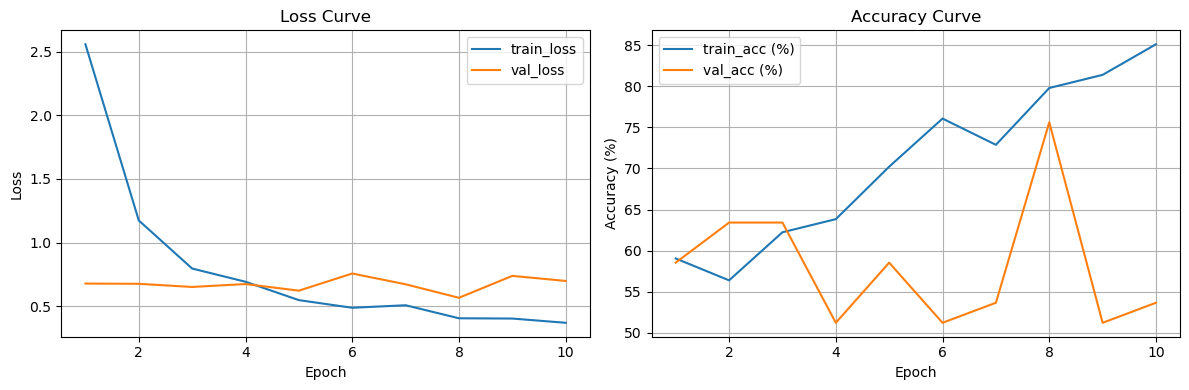

In [ ]:
## 전체 학습 수 체크
epochs = list(range(1, EPOCHS + 1))

## 가로로 넓게
plt.figure(figsize=(12, 4))  

## =========================================
## [6-1] Loss Curve
## =========================================
plt.figure(figsize=(12, 4))  # 가로로 넓게
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)


## =========================================
## [6-1] Accuracy Curve
## =========================================
plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in history["train_acc"]], label="train_acc (%)")
plt.plot(epochs, [a * 100 for a in history["val_acc"]],  label="val_acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


[7] 예측 <hr>

In [ ]:
# =========================
# 샘플데이터에 대한 예측 
# =========================
af.show_predictions(model, test_loader, train_ds.classes, DEVICE, n=10)

Sample predictions:
- GT: cat   | Pred: cat   [O]
- GT: cat   | Pred: cat   [O]
- GT: cat   | Pred: dog   [X]
- GT: cat   | Pred: dog   [X]
- GT: cat   | Pred: cat   [O]
- GT: cat   | Pred: dog   [X]
- GT: cat   | Pred: dog   [X]
- GT: cat   | Pred: dog   [X]
- GT: cat   | Pred: cat   [O]
- GT: cat   | Pred: cat   [O]
